In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

In [2]:
df = pd.read_csv('./kaggle_data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Cleaning Up the Data
1. Converting categorical cols, rating cols, and continuous cols to a format an ML model can read
2. Splitting this data 80-20 for testing purposes
3. Removing NaNs

In [3]:
# These are the manually picked columns that are all categorical
total_categorical_cols = ['MSZoning', 'Street', 'Alley', 'LandContour', 
                    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'ExterCond', 'Foundation', 'Heating', 'CentralAir', 'PavedDrive',
                    'MiscFeature', 'SaleType', 'SaleCondition']

# These columns will have to be manually processed
total_rating_cols = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

#########
# Below will be the columns actually used in the model
#########

exclude_cols = ['Id', 'SalePrice']

category_cols = total_categorical_cols.copy()
rating_cols = total_rating_cols.copy()
continuous_cols = [col for col in df.columns if col not in category_cols and col not in rating_cols and col not in exclude_cols]

In [4]:
# Take rating columns and convert to numerical scale
rating_df = df.copy()[rating_cols]

replace_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,
               'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4,
               'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1,
               'Gtl': 1, 'Mod': 2, 'Sev': 3,
               'NA': 0,
               'Av': 3, 'Mn': 2, 'No': 1,
               'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
               'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1,
               'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1,
               '2Types': 6, 'Attchd': 5, 'Basment': 4, 'BuiltIn': 3, 'CarPort': 2, 'Detchd': 1,
               'Fin': 3, 'RFn': 2, 'Unf': 1,
               'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}

rating_df.replace(replace_dict, inplace=True)

na_to_zero_cols = ['LotShape', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual',
                   'PoolQC', 'Fence', 'Electrical']

na_to_zero_cols = [col for col in na_to_zero_cols if col in rating_df]

rating_df[na_to_zero_cols] = rating_df.loc[:, na_to_zero_cols].fillna(0)

In [5]:
# Select categorical columns and get dummy column values (different approach from what we did before with category type)
# Preferably pick columns that are not like rating columns (Bad, Okay, Great). We should handle those separately
dummy_df = pd.get_dummies(df[category_cols])

In [6]:
YVar = df[['SalePrice']]
XVar = pd.concat([df[continuous_cols], dummy_df, rating_df], axis=1)

# Filter out nan values
YVar = YVar[XVar.notna().all(axis='columns')]
XVar = XVar[XVar.notna().all(axis='columns')]

# TODO GO BACK AND FIGURE OUT WHERE ALL THESE NANS ARE COMING FROM
print('Num rows after filtering out nans: ' + str(len(XVar)))
print('Percent remaining after filtering: ' + str(round(len(XVar) / len(df) * 100)) + '%')

XVar = XVar.apply(pd.to_numeric)

Num rows after filtering out nans: 1121
Percent remaining after filtering: 77%


In [7]:
# Split data 80-20 so we can test how well the model works
msk = np.random.rand(len(XVar)) < 0.8

train_x = XVar[msk]
train_y = YVar[msk]

test_x = XVar[~msk]
test_y = YVar[~msk]

print(train_x.shape)

(901, 220)


# Univariate Feature Selection
1. Find x best columns to use based on univariate feature selection
2. Produce univariate_train_x which selects those columns from train_x

In [20]:
# Try running Univariate feature selection with chi^2 (supposed to work well for sparse data)
selector = SelectKBest(chi2, k=180)
selector.fit_transform(train_x, train_y)

univ_feature_mask = selector.get_support()
univ_features = []

for b, feature in zip(univ_feature_mask, train_x.columns):
    if b: 
        univ_features.append(feature)
        
univariate_train_x = train_x[univ_features]
univariate_test_x = test_x[univ_features]

univariate_train_x

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,LandSlope,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,PoolQC,Fence
0,60,65.0,8450,7,2003,2003,196.0,706,0,150,...,1,4.0,1.0,6.0,1.0,0.0,5.0,2.0,0.0,0.0
1,20,80.0,9600,6,1976,1976,0.0,978,0,284,...,1,4.0,4.0,5.0,1.0,3.0,5.0,2.0,0.0,0.0
3,70,60.0,9550,7,1915,1970,0.0,216,0,540,...,1,3.0,1.0,5.0,1.0,4.0,1.0,1.0,0.0,0.0
4,60,84.0,14260,8,2000,2000,350.0,655,0,490,...,1,4.0,3.0,6.0,1.0,3.0,5.0,2.0,0.0,0.0
5,50,85.0,14115,5,1993,1995,0.0,732,0,64,...,1,4.0,1.0,6.0,1.0,0.0,5.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,1999,2000,0.0,0,0,953,...,1,4.0,1.0,1.0,1.0,3.0,5.0,2.0,0.0,0.0
1456,20,85.0,13175,6,1978,1988,119.0,790,163,589,...,1,4.0,1.0,5.0,3.0,3.0,5.0,1.0,0.0,3.0
1457,70,66.0,9042,7,1941,2006,0.0,275,0,877,...,1,3.0,1.0,6.0,1.0,4.0,5.0,2.0,0.0,4.0
1458,20,68.0,9717,5,1950,1996,0.0,49,1029,0,...,1,3.0,2.0,6.0,3.0,0.0,5.0,1.0,0.0,0.0


# Run Linear Regression and Perform Analysis
1. Create model on univariate/rfecv data
2. Test model on test_x dataset
3. View results, average difference, residuals

In [21]:
# Run linear regression with sklearn
regr = linear_model.LinearRegression()
regr.fit(univariate_train_x, train_y)

# Make predictions using the testing set, then convert to pandas series
saleprice_preds = regr.predict(univariate_test_x)
saleprice_preds = pd.Series([x for lst in saleprice_preds for x in lst])

# Print out coefficient information
#print('Coefficients: \n', regr.coef_)
r2 = metrics.r2_score(test_y, saleprice_preds)
print('r2: ', round(r2,4))

r2:  0.8626


In [22]:
# Construct the results dataframe
actual_price = test_y.reset_index()['SalePrice']
pred_price = saleprice_preds.round()

res = pd.DataFrame({'actual_price': actual_price, 'predicted_price': pred_price})
res

,actual_price,predicted_price
0,223500,211403.0
1,306000,304039.0
2,68500,51929.0
3,160000,147956.0
4,170000,173607.0
...,...,...
215,310000,314534.0
216,129000,135229.0
217,112000,90423.0
218,287090,280730.0


In [23]:
res['residual'] = res.actual_price - res.predicted_price
res['percent_diff'] = (res['residual'] / res.actual_price * 100).round(decimals=2)
res

,actual_price,predicted_price,residual,percent_diff
0,223500,211403.0,12097.0,5.41
1,306000,304039.0,1961.0,0.64
2,68500,51929.0,16571.0,24.19
3,160000,147956.0,12044.0,7.53
4,170000,173607.0,-3607.0,-2.12
...,...,...,...,...
215,310000,314534.0,-4534.0,-1.46
216,129000,135229.0,-6229.0,-4.83
217,112000,90423.0,21577.0,19.27
218,287090,280730.0,6360.0,2.22


In [24]:
print('Average percent_difference: %.2f' % (res.percent_diff.abs().mean()))

Average percent_difference: 12.11


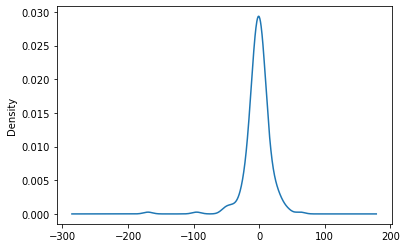

In [28]:
res.percent_diff.plot.kde()

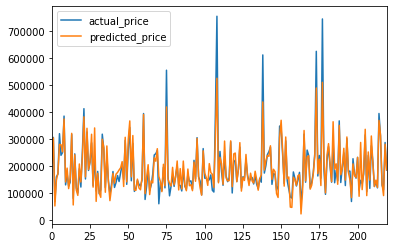

In [25]:
# Predicted price is actually really close to actual, but not when actual price is very very high
res.plot(kind='line', y=['actual_price', 'predicted_price'])

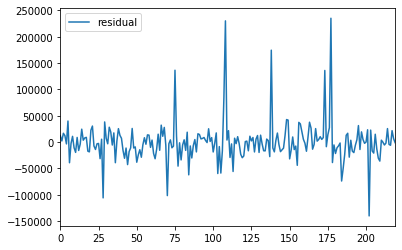

In [26]:
res.plot(kind='line', y='residual')